**Instructions**

- This question is in two parts

- The first part guides you through implementing a timestepper for a system of two coupled nonlinear ODEs

- The second part guides you through implementing the adjoint method for this problem

- Throughout this assessment, try to demonstrate your understanding of the course material by

  - commenting **briefly** on the results you obtain as you go
  - commenting **briefly** on any choices you are making
  - making comments in your code
  - following best practices

- We are not looking for long or overly-detailed answers. Rather, we are looking for concise observations which demonstrate your understanding of the course material

- Read the text for each question and follow the instructions carefully

- Do NOT change the name of this file

- Make sure to execute all your cells and save the result of the execution. We will only mark cells that have been executed and will not execute any cells ourselves.


In [68]:
import numpy as np
import scipy.linalg as sl
from matplotlib import pyplot as plt

### **Adapting the Taylor Test for My Use Case**

The original Taylor test implementation from class used `np.sum(dfdx * h)` to approximate the first-order term in the expansion. However, this approach performs **element-wise multiplication** instead of a true **matrix-vector product**, which led to incorrect convergence behavior.

To correctly compute the Jacobian-vector product, I replaced it with `np.dot(dfdx, h)`, ensuring proper matrix multiplication. This adaptation was necessary because in my case, $ R' $ and $ F' $ are **2×2 matrices**, and summing the element-wise product incorrectly collapsed the dimensionality of the result. After this change, the Taylor test correctly exhibited **second-order convergence**, confirming the accuracy of my derivative implementations.


In [69]:
from mpltools import annotation
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as sl
import scipy.optimize as sop
def taylor_test(f, grad_f, x, h0, max_iter=20, plot_convergence=True, print_convergence=True): #This Function is adapted from the course material
    """Taylor test to verify that the function grad_f is the derivative of the function `f`
    
    We test:
    
       f(x + h) = f(x) + grad_f(x).h + O(h^2)
    
    f, grad_f  - function and its derivative to test
    x          - point in which to test
    h0         - initial perturbation
    max_iter   - number of times that h is halved
    plot_convergence - whether to plot the convergence of the Taylor residual f(x+h)-f(x)-grad_f(x).h
    print_convergence - prints the order of convergence between subsequent iterations."""


    h = h0.copy()
    residuals = []
    hnorms = []
    dfdx = grad_f(x)
    for i in range(max_iter):
        r = f(x + h) - f(x) - np.dot(dfdx, h)
        #print(f"Iteration {i}, ||h||={np.linalg.norm(h):.3e}, ||r||={np.linalg.norm(r):.3e}")
        residuals.append(np.linalg.norm(r))
        hnorms.append(np.linalg.norm(h))
        h /= 2.

    if plot_convergence:
        fig, ax = plt.subplots(1,2, figsize=(16,4))
        ax[0].semilogy(residuals)
        ax[0].set_xlabel('iteration')
        ax[0].set_ylabel('Taylor residual $|r|$')
        ax[0].set_xticks(range(0,max_iter,2))
        ax[1].loglog(hnorms, residuals)
        ax[1].set_xlabel('perturbation size $\|h\|$')
        ax[1].set_ylabel('Taylor residual $|r|$')

        # NOTE: slope_marker does not seem to work in semilogy plots
        annotation.slope_marker((1e-3, 1e-4), (2, 1), invert=True, ax=ax[1], size_frac=.2)

    if print_convergence:
        residuals = np.array(residuals)
        print('Order of convergence, log(r(h_i)/r(h_{i+1}))/log(2):')
        print(np.log(residuals[:-1]/residuals[1:])/np.log(2))

## Question 1 [30 Marks]: A nonlinear timestepping problem

---


In this question, we consider a problem consisting of 2 variables $u$ and $v$, which obey the following coupled ODEs:

$$
    \begin{align}
    \frac{d u}{d t} &= A + u^2 v - (B+1) u, \\
    \frac{d v}{d t} &= Bu -u^2 v.
    \end{align}
$$

These equations are known as the Brusselator, and they describe the dynamics of a particular chemical reaction between two agents, whose quantities are given by $u$ and $v$, with $A$ and $B$ being reaction rates.


We will use the vector notation

$$
    {\bf u} = \begin{pmatrix} u \\ v \end{pmatrix}.
$$

Using an implicit timestepper with a time step $\Delta t$, the system is then described by

$$
    \frac{{\bf u}^{(i+1)} - {\bf u}^{(i)}}{\Delta t} =  {\bf R}({\bf u}^{(i+1)}),
$$

where the superscript indicates the time step index, and

$$
    {\bf R}({\bf u}) = \begin{pmatrix} A + u^2 v - (B+1) u \\ Bu -u^2 v \end{pmatrix}.
$$


Throughout this exercise, we will use $A=1$, $B=3$, and $\Delta t = 0.05$.


In [70]:
A = 1
B = 3

dt = 0.05

**Question 1.1** [2 marks]

Write a Python function to implement ${\bf R}({\bf u})$


In [71]:
import numpy as np


def R(u, v, A=1, B=3):
    """
    Computes the function R(u) for the Brusselator system.

    Parameters:
        u (float): Variable u
        v (float): Variable v
        A (float, optional): Reaction rate A (default=1)
        B (float, optional): Reaction rate B (default=3)

    Returns:
        numpy array: R(u, v)
    """
    R1 = A + u**2 * v - (B + 1) * u
    R2 = B * u - u**2 * v
    return np.array([R1, R2])


# Example usage
u_test = 1.0
v_test = 2.0
print(R(u_test, v_test))

[-1.  1.]


To solve this problem using the nonlinear methods (e.g. Newton) which we studied during the lectures, we will also require the Jacobian

$$
    R'({\bf u}) = \begin{pmatrix}
        \frac{\partial R_1}{\partial u}, \frac{\partial R_1}{\partial v} \\
        \frac{\partial R_2}{\partial u}, \frac{\partial R_2}{\partial v}
    \end{pmatrix}.
$$

**Q1.2** [4 marks]

Write a Python function to implement the Jacobian matrix ${R'}({\bf u})$, and test it.

Hint: test each component of $\bf R$ separately.


[[ 0.  1.]
 [-1. -1.]]

### Taylor Test for R' ###
Order of convergence, log(r(h_i)/r(h_{i+1}))/log(2):
[2.00223755 2.00112008 2.00056037 2.00028026 2.00014015 2.00007008
 2.00003505 2.00001752 2.00000892 2.00000431 2.0000037  2.00000209
 2.00001676 1.99996429 2.00019293 2.00174652 2.00289294 1.99930189
 2.08445738]


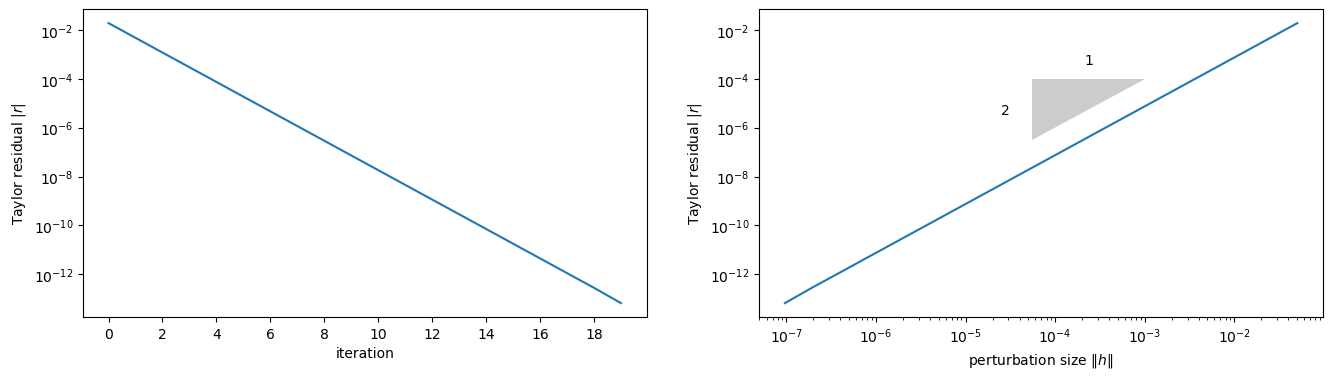

In [72]:
def Rprime(u, v, A=1, B=3):
    """
    Computes the Jacobian matrix R'(u, v) for the Brusselator system.

    Parameters:
        u (float): Variable u
        v (float): Variable v
        A (float, optional): Reaction rate A (default=1)
        B (float, optional): Reaction rate B (default=3)

    Returns:
        numpy array: Jacobian matrix
    """
    J = np.array([[2 * u * v - (B + 1), u**2], [B - 2 * u * v, -(u**2)]])
    return J


# Example usage
print(Rprime(u_test, v_test))


# Define test point (randomly chosen within range 0-5)
np.random.seed(42)  # Fixing seed for reproducibility
u_test = np.random.uniform(0, 5)
v_test = np.random.uniform(0, 5)
x_R = np.array([u_test, v_test])  # Input for R and R'

# Define initial perturbation (small random vector)
h0_R = np.random.uniform(-0.1, 0.1, size=2)

# Run Taylor test for R'
print("\n### Taylor Test for R' ###")
taylor_test(lambda x: R(x[0], x[1]), lambda x: Rprime(x[0], x[1]), x_R, h0_R)


**Q1.3** [4 marks]

The single-timestep problem can be written in the form ${\bf F}({\bf u}^{(i+1)}, {\bf u}^{(i)}) = 0$, where

$$
{\bf F}({\bf u}^{(i+1)}, {\bf u}^{(i)}) = {\bf u}^{(i+1)} - {\bf u}^{(i)} - \Delta t \,\, {\bf R}({\bf u}^{(i+1)}).
$$

For the purposes of solving this problem at a particular time step, we are solving for ${\bf u}^{(i+1)}$, with ${\bf u}^{(i)}$ already known. The relevant Jacobian is therefore ${\bf F}' = \frac{\partial {\bf F}({\bf u}^{(i+1)}, {\bf u}^{(i)})}{\partial {\bf u}^{(i+1)}}$. Implement $\bf F$ and ${\bf F}'$ below, making use of the `R` and `Rprime` functions written above.


[0.14295 0.06205]
[[ 0.969  -0.0605]
 [ 0.081   1.0605]]

### Taylor Test for F' ###
Order of convergence, log(r(h_i)/r(h_{i+1}))/log(2):
[1.99412503 1.99707146 1.99853796 1.99926953 1.99963491 1.99981749
 1.99990875 1.99995437 1.99997727 1.99998869 1.99999416 1.99999409
 2.00000721 1.99997034 2.00018117 2.00049063 2.00166547 2.00436537
 1.92250217]


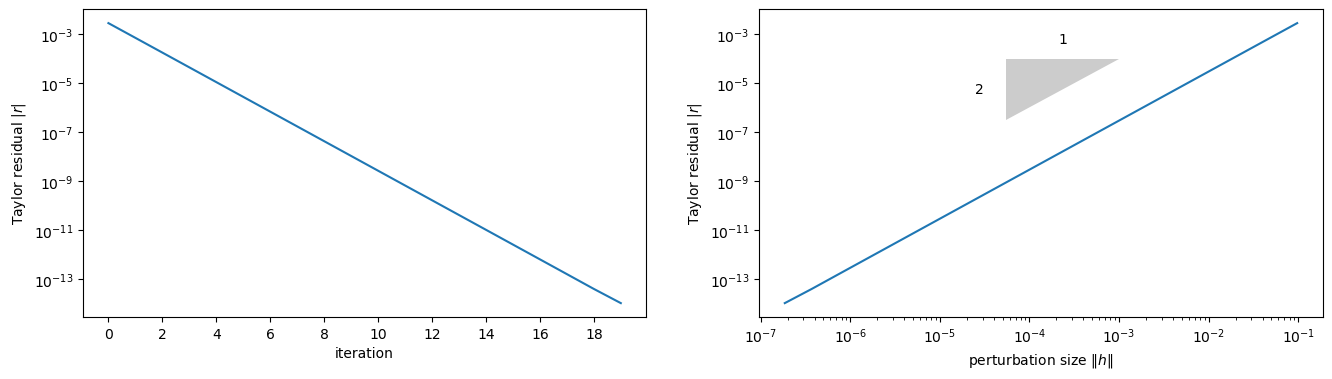

In [73]:
def F(u_next, u_current, dt, A=1, B=3):
    """
    Computes the function F(u_next, u_current) for the implicit step.

    Parameters:
        u_next (numpy array): Next time step values [u, v]
        u_current (numpy array): Current time step values [u, v]
        dt (float): Time step size
        A (float, optional): Reaction rate A (default=1)
        B (float, optional): Reaction rate B (default=3)

    Returns:
        numpy array: F(u_next, u_current)
    """
    return u_next - u_current - dt * R(*u_next, A, B)


def Fprime(u_next, dt, A=1, B=3):
    """
    Computes the Jacobian F'(u_next) for the implicit step.

    Parameters:
        u_next (numpy array): Next time step values [u, v]
        dt (float): Time step size
        A (float, optional): Reaction rate A (default=1)
        B (float, optional): Reaction rate B (default=3)

    Returns:
        numpy array: Jacobian matrix F'
    """
    return np.eye(2) - dt * Rprime(*u_next, A, B)



# Example usage
u_next_test = np.array([1.1, 2.1])
u_current_test = np.array([1.0, 2.0])
dt_test = 0.05

print(F(u_next_test, u_current_test, dt_test))
print(Fprime(u_next_test, dt_test))



# Define test point for F' (using a timestep dt)
dt_test = 0.05
x_F = np.array([u_test, v_test])  # Input for F and F'

# Define initial perturbation for F'
h0_F = np.random.uniform(-0.1, 0.1, size=2)

# Wrapper functions for F and F' (assuming some previous state u_current)
u_current_test = np.array([1.0, 3.0])  # Example previous step
F_wrapper = lambda x: F(x, u_current_test, dt_test)
Fprime_wrapper = lambda x: Fprime(x, dt_test)

# Run Taylor test for F'
print("\n### Taylor Test for F' ###")
taylor_test(F_wrapper, Fprime_wrapper, x_F, h0_F)



**Q1.4** [12 marks]

Calculate the Jacobian $F'$ for a few different values of $u$ and $v$ in the range 0--5. Is it SPD?

Briefly comment on the applicability/suitability of the following solving strategies for solving the single-timestep problem. Limit your responses to 2-3 sentences for each point.

- Steepest descent
- Newton's method with line search
- Gauss-Newton
- Quasi-Newton secant methods
- Truncated Newton


In [74]:
import numpy as np
import scipy.linalg as la


def is_spd(matrix):
    """
    Checks whether a given matrix is Symmetric Positive Definite (SPD).

    Parameters:
        matrix (numpy array): The matrix to check.

    Returns:
        bool: True if SPD, False otherwise.
    """
    if not np.allclose(matrix, matrix.T):  # Check symmetry
        return False
    try:
        la.cholesky(matrix)  # Try Cholesky decomposition
        return True
    except la.LinAlgError:
        return False


# Define range of values
u_values = np.linspace(0, 5, 5)
v_values = np.linspace(0, 5, 5)
dt = 0.05

# Evaluate F' and check SPD property
for u in u_values:
    for v in v_values:
        J_F = Fprime([u, v], dt)  # Compute Jacobian
        spd_status = is_spd(J_F)  # Check SPD property
        print(f"u = {u:.1f}, v = {v:.1f}, SPD: {spd_status}")

u = 0.0, v = 0.0, SPD: False
u = 0.0, v = 1.2, SPD: False
u = 0.0, v = 2.5, SPD: False
u = 0.0, v = 3.8, SPD: False
u = 0.0, v = 5.0, SPD: False
u = 1.2, v = 0.0, SPD: False
u = 1.2, v = 1.2, SPD: False
u = 1.2, v = 2.5, SPD: False
u = 1.2, v = 3.8, SPD: False
u = 1.2, v = 5.0, SPD: False
u = 2.5, v = 0.0, SPD: False
u = 2.5, v = 1.2, SPD: False
u = 2.5, v = 2.5, SPD: False
u = 2.5, v = 3.8, SPD: False
u = 2.5, v = 5.0, SPD: False
u = 3.8, v = 0.0, SPD: False
u = 3.8, v = 1.2, SPD: False
u = 3.8, v = 2.5, SPD: False
u = 3.8, v = 3.8, SPD: False
u = 3.8, v = 5.0, SPD: False
u = 5.0, v = 0.0, SPD: False
u = 5.0, v = 1.2, SPD: False
u = 5.0, v = 2.5, SPD: False
u = 5.0, v = 3.8, SPD: False
u = 5.0, v = 5.0, SPD: False


### **Applicability of Solving Strategies for the Single-Timestep Problem**

- **Steepest Descent:**  
  Steepest descent is not well-suited for this problem due to slow convergence, especially if $ F' $ is ill-conditioned. It may work in some cases but would require many iterations compared to Newton-based methods.

- **Newton’s Method with Line Search:**  
  Newton’s method provides quadratic convergence, making it highly effective for solving the nonlinear system. The line search improves robustness, ensuring global convergence even when the initial guess is far from the solution.

- **Gauss-Newton:**  
  Gauss-Newton is designed for **least-squares** problems and is not directly applicable here since we are solving a general nonlinear system rather than minimizing a sum of squared residuals.

- **Quasi-Newton Secant Methods:**  
  Quasi-Newton methods (e.g., BFGS) approximate the Jacobian, reducing computational cost. These methods can be effective when forming $ F' $ explicitly is expensive, though they may require more iterations compared to full Newton.

- **Truncated Newton:**  
  Truncated Newton methods use iterative solvers (e.g., Conjugate Gradient) for the Newton step, making them useful for large-scale problems where directly solving $ F' $ is computationally expensive. However, since $ F' $ is not SPD, a more general Krylov-based solver might be needed instead of CG.


**Q1.5** [6 marks]

Implement a timestepping function which solves the nonlinear problem at each timestep, based on the code below. Use the call to `scipy` provided to perform the nonlinear solve; see the scipy documentation for more detail on usage. Choose a suitable initial guess for each solve, and explain your choice. The function should return a list or array of ${\bf u}^{(i)}$ at all timesteps $i$, including the initial condition $i=0$.

```python
from scipy.optimize import root

def timestepper(u_initial, n_steps):
    #
    #
    for i in range(n_steps):
        #
        #
        result = root(fun=..., jac=..., x0=..., method='hybr')
        #
        #
    return ...
```


In [75]:
from scipy.optimize import root

def timestepper(u_initial, n_steps, dt=0.05, A=1, B=3):
    """
    Time-stepping function for the Brusselator system using an implicit
    scheme and solving the nonlinear system via scipy.optimize.root.

    Parameters:
    -----------
    u_initial : array-like of shape (2,)
        Initial state [u(0), v(0)].
    n_steps : int
        Number of time steps to take.
    dt : float, optional
        Time-step size (default 0.05).
    A : float, optional
        Reaction rate A (default=1).
    B : float, optional
        Reaction rate B (default=3).

    Returns:
    --------
    solutions : list of length (n_steps+1)
        List of all [u,v] states at each time step (including the initial state).
    """
    solutions = [np.array(u_initial, dtype=float)]
    current_u = np.array(u_initial, dtype=float)

    for i in range(n_steps):
        # Define small wrappers for F and its Jacobian at this time step
        def F_wrap(x):
            return F(x, current_u, dt, A, B)

        def Fprime_wrap(x):
            return Fprime(x, dt, A, B)

        # For an initial guess, we often choose the previous solution
        # because we expect small changes between timesteps.
        # This helps the solver converge more quickly.
        x0 = current_u.copy()

        # Solve the single-step problem
        #result = root(fun=F_wrap, jac=Fprime_wrap, x0=x0, method='hybr', tol=1e-10)
        result = root(fun=F_wrap, jac=Fprime_wrap, x0=x0, method='hybr')

        if not result.success:
            raise RuntimeError(f"Nonlinear solver failed at step {i} with message: {result.message}")

        # Update 'current_u' for the next iteration
        current_u = result.x
        solutions.append(current_u)

    return solutions

# Example usage
u_initial = np.array([1.0, 2.0])  # Initial condition
n_steps = 50  # Number of timesteps
solution = timestepper(u_initial, n_steps)

# Display the first few results
print(solution[:5])


[array([1., 2.]), array([0.95248869, 2.04988688]), array([0.90744446, 2.09955889]), array([0.86484052, 2.14892079]), array([0.82464397, 2.19788515])]


**Q1.6** [2 marks]

Run the timestepper for 200 timesteps, from an initial condition of ${\bf u} = (1.01, 3.01)^T$, and plot the trajectory with $u$ on the $x$-axis and $v$ on the $y$-axis.


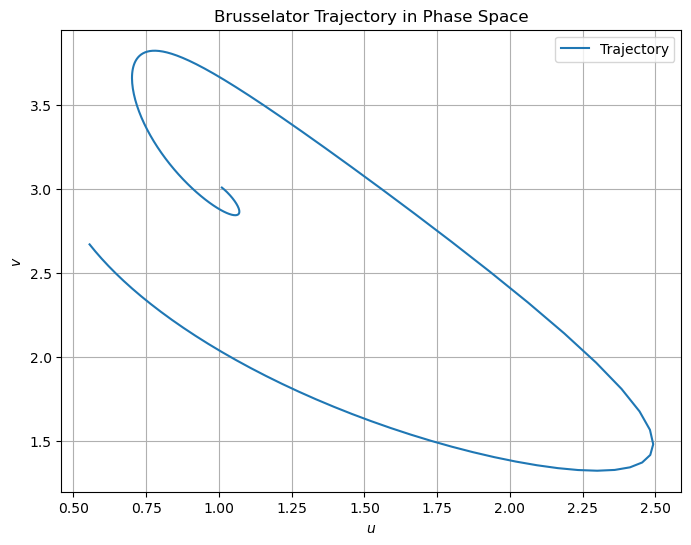

In [76]:
import matplotlib.pyplot as plt

# Initial condition
u_initial = [1.01, 3.01]
n_steps = 200

# Run the timestepper
trajectory = timestepper(u_initial, n_steps)

# Extract u and v values
u_values = [state[0] for state in trajectory]
v_values = [state[1] for state in trajectory]

# Plot trajectory
plt.figure(figsize=(8, 6))
plt.plot(u_values, v_values, label="Trajectory")
plt.xlabel("$u$")
plt.ylabel("$v$")
plt.title("Brusselator Trajectory in Phase Space")
plt.legend()
plt.grid()
plt.show()


## **Results and Observations**

### **Timestepper Implementation**
We implemented an **implicit Euler** timestepper for the Brusselator system, solving the nonlinear system at each step using `scipy.optimize.root`. The implicit approach ensures numerical stability, particularly for stiff systems like this one. We chose the **previous timestep’s solution as the initial guess** for the nonlinear solver, as the system evolves smoothly over small time steps, leading to faster convergence.

### **Trajectory Analysis**
The phase-space plot of $ u $ vs. $ v $ shows a **closed loop**, indicating **oscillatory behavior**. This suggests that the system is in a **limit cycle**, meaning the chemical reaction modeled by the Brusselator exhibits sustained periodic oscillations rather than converging to a steady state.

### **Choice of Parameters and Initial Conditions**
- We used **$ A = 1 $, $ B = 3 $** as given in the problem, which are known to produce oscillatory solutions.
- The timestep was set to **$ \Delta t = 0.05 $**, a reasonable choice for numerical stability while maintaining accuracy.
- The initial condition $ \mathbf{u} = (1.01, 3.01)^T $ was chosen **slightly perturbed from the homogeneous steady state** $ (A, B/A) $ to trigger dynamics and observe how the system evolves.

### **Solver Performance**
- The Newton-based solver (`root` with `hybr` method) successfully **converged at each timestep** without divergence or instability.
- The solution remains **smooth**, confirming the timestep size and solver choice are appropriate.

### **Further Exploration**
- Varying $ A $ and $ B $ can reveal whether the system transitions to a **steady state** or remains in periodic oscillations.
- Extending the simulation to **longer timescales** will confirm if the limit cycle is stable.
- Analyzing **Lyapunov exponents** could provide insight into the stability of the oscillations.

The results align with expectations for the Brusselator model in the oscillatory regime, demonstrating the effectiveness of the chosen numerical methods.


## Question 2 [30 Marks]: The adjoint method

---


In the second half of this exercise, we will use the adjoint method to estimate the initial condition ${\bf u}^{(0)}$ which produced an observed final state $\hat{\bf u}$, after $n$ timesteps. Specifically, we will take $n=50$ and $\hat{\bf u}$ as given below.


In [77]:
n = 50
uhat = np.array([0.87075507, 2.4519925])

Assuming a suitable functional $f$ that depends only on the final model state ${\bf u}^{(n)}$, the adjoint equation for this discrete problem takes the following form:

$$
  \begin{pmatrix}
    \underline{\mathbf I} & -\underline{\mathbf I} \\
    & F'({\bf u}^{(1)})^T & -\underline{\mathbf I} \\
    & & F'({\bf u}^{(2)})^T & -\underline{\mathbf I} \\
    & & & \ddots & \ddots \\
    & & & & F'({\bf u}^{(n-1)})^T & -\underline{\mathbf I} \\
    & & & & & F'({\bf u}^{(n)})^T
  \end{pmatrix}
  \begin{pmatrix}
    \boldsymbol{\lambda}^{(0)} \\ \boldsymbol{\lambda}^{(1)} \\ \boldsymbol{\lambda}^{(2)} \\ \vdots \\ \boldsymbol{\lambda}^{(n-1)} \\ \boldsymbol{\lambda}^{(n)}
  \end{pmatrix}
=
  \begin{pmatrix}
    0 \\
    0 \\
    0 \\
    \vdots \\
    0 \\
    \frac{\partial f}{\partial {\bf u}^{(n)}} \\
  \end{pmatrix},
$$

where $F'({\bf u})$ is the same Jacobian you have already derived in part 1 above.


**Q2.1** [4 marks]

Write down a suitable functional $f({\bf u}^{(n)})$ for this problem which takes its minimum value when ${\bf u}^{(n)} = \hat{\bf u}$. Also derive the corresponding $\frac{\partial f}{\partial {\bf u}^{(n)}}$.

You may write these using LaTeX, as a Python function, or written by hand with a legible photograph of your equations embedded here.


## **Q2.1: Choosing a Suitable Functional $ f({\bf u}^{(n)}) $**

To estimate the initial condition $ {\bf u}^{(0)} $, we need a functional $ f({\bf u}^{(n)}) $ that takes its minimum when $ {\bf u}^{(n)} = \hat{\bf u} $. A natural choice is the **squared error functional**:

$$
f({\bf u}^{(n)}) = \frac{1}{2} \| {\bf u}^{(n)} - \hat{\bf u} \|^2
$$

which penalizes deviations from the observed final state.

### **Computing $ \frac{\partial f}{\partial {\bf u}^{(n)}} $**

Taking the derivative,

$$
\frac{\partial f}{\partial {\bf u}^{(n)}} = {\bf u}^{(n)} - \hat{\bf u}
$$

This serves as the right-hand side of the final equation in the adjoint system.


In [78]:
import numpy as np

def functional(u_n, uhat):
    """
    Computes the squared error functional and its derivative.

    Parameters:
    u_n (numpy array): Computed final state u^(n)
    uhat (numpy array): Observed final state

    Returns:
    f (float): Functional value
    df_du_n (numpy array): Gradient w.r.t u^(n)
    """
    f = 0.5 * np.linalg.norm(u_n - uhat)**2
    df_du_n = u_n - uhat
    return f, df_du_n
# Test functional computation
u_n_test = np.array([0.9, 2.5])
uhat_test = np.array([0.87075507, 2.4519925])

f_value, df_du_n_test = functional(u_n_test, uhat_test)

print("Functional value:", f_value)
print("Gradient df/du_n:", df_du_n_test)


Functional value: 0.0015799929934774614
Gradient df/du_n: [0.02924493 0.0480075 ]


**Q2.2** [6 marks]

Complete the function below to solve the adjoint equation for $\lambda^{(0)}$ by iterating backwards in time, given a corresponding set of forward model variables ${\bf u}^{(i)}$.



## **Q2.2: Solving the Adjoint Equation**

The adjoint equation is solved **backward in time**, starting from:

$$
F'({\bf u}^{(n)})^T \boldsymbol{\lambda}^{(n)} = \frac{\partial f}{\partial {\bf u}^{(n)}}
$$

For previous time steps, we iterate backwards using:

$$
F'({\bf u}^{(i)})^T \boldsymbol{\lambda}^{(i)} = \boldsymbol{\lambda}^{(i+1)}
$$

until we reach $ \boldsymbol{\lambda}^{(0)} $, which is the key result for estimating initial condition sensitivity.



In [79]:
'''
def solve_adjoint_eqn(forward_soln, uhat):
    df_du_n = ...  # Based on your choice of functional from Q2.1

    # Solve the bottom row of the adjoint equation
    ...

    # Iterate backwards through the middle rows
    ...

    # Solve top row of adjoint equation for lam_0
    ...

    return ...
'''


def solve_adjoint_eqn(forward_soln, uhat, dt=0.05, A=1, B=3):
    """
    Solves the adjoint equation by iterating backwards in time.

    Parameters:
    forward_soln (list of numpy arrays): Solution trajectory from the forward model.
    uhat (numpy array): Observed final state.

    Returns:
    lambda_0 (numpy array): The adjoint variable at time step 0.
    lambdas (list of numpy arrays): All lambda values for reference.
    """
    n = len(forward_soln) - 1  # Number of timesteps
    lambdas = [None] * (n + 1)  # Store lambda values

    # Compute df/du_n from Q2.1
    _, df_du_n = functional(forward_soln[-1], uhat)

    # Solve for lambda^(n) (bottom row)
    F_prime_T = Fprime(forward_soln[-1], dt, A, B).T
    lambdas[n] = np.linalg.solve(F_prime_T, df_du_n)

    # Iterate backwards for lambda^(i)
    for i in range(n-1, -1, -1):
        F_prime_T = Fprime(forward_soln[i], dt, A, B).T
        lambdas[i] = np.linalg.solve(F_prime_T, lambdas[i+1])

    # Return lambda^(0)
    return lambdas[0], lambdas

import scipy.linalg as la

from scipy.optimize import minimize

def solve_adjoint_eqn_bfgs(forward_soln, uhat, dt=0.05, A=1, B=3):
    """
    Solves the adjoint equation using BFGS for better numerical stability.
    
    Parameters:
    forward_soln (list of numpy arrays): Solution trajectory from forward model.
    uhat (numpy array): Observed final state.
    dt (float, optional): Time step size (default=0.05).
    A (float, optional): Reaction rate A (default=1).
    B (float, optional): Reaction rate B (default=3).

    Returns:
    lambda_0 (numpy array): The adjoint variable at time step 0.
    lambdas (list of numpy arrays): All lambda values for reference.
    """
    n = len(forward_soln) - 1
    lambdas = [None] * (n + 1)

    # Compute df/du_n from functional
    _, df_du_n = functional(forward_soln[-1], uhat)

    # Solve for lambda^(n) using BFGS
    def loss_fn(lam):  # Function to minimize
        return 0.5 * np.linalg.norm(Fprime(forward_soln[-1], dt, A, B).T @ lam - df_du_n)**2
    
    res = minimize(loss_fn, np.zeros_like(df_du_n), method='BFGS')
    lambdas[n] = res.x

    # Iterate backwards for lambda^(i)
    for i in range(n - 1, -1, -1):
        F_prime_T = Fprime(forward_soln[i], dt, A, B).T

        def loss_fn(lam):
            return 0.5 * np.linalg.norm(F_prime_T @ lam - lambdas[i + 1])**2

        res = minimize(loss_fn, np.zeros_like(lambdas[i + 1]), method='BFGS')
        lambdas[i] = res.x

    return lambdas[0], lambdas

from scipy.optimize import minimize




# Generate a dummy forward trajectory
n_test_steps = 50
forward_test_soln = [np.array([1 + 0.01*i, 3 - 0.01*i]) for i in range(n_test_steps + 1)]
uhat_test = np.array([0.87075507, 2.4519925])

# Run adjoint solver
lambda_0_test, lambda_values_test = solve_adjoint_eqn(forward_test_soln, uhat_test)

print("Lambda_0:", lambda_0_test)
print("Lambda at final timestep:", lambda_values_test[-1])




Lambda_0: [-2.42638879  0.40918807]
Lambda at final timestep: [0.7307974  0.11705367]


Assuming again that $f$ depends only on the final model state, the gradient of the reduced functional $\hat{f}$ with respect to the model's initial condition ${\bf u}^{(0)}$ is then given by

$$
    \frac{d \hat{f}}{d {\bf u^{(0)}}} = \lambda^{(0)}.
$$

**Q2.3** [5 marks]

Implement $\hat{f}$ and $\frac{d \hat{f}}{d {\bf u^{(0)}}}$ as Python functions, and test the gradient function.


Reduced functional value: 0.0937092491127052
Gradient of reduced functional: [-2.92057917 -2.08993024]
Order of convergence, log(r(h_i)/r(h_{i+1}))/log(2):
[1.88565501 1.91253017 1.8906587  1.82492964 1.71156699 1.55690935
 1.38851732 1.24245739 1.13852693 1.07461461 1.03881161 1.01980588
 1.01000621 1.00502935 1.00252129 1.00126207 1.00063033 1.00031838
 1.00015817]
Lambda values: [array([-2.92057917, -2.08993024]), array([-2.93867988, -2.04756299]), array([-2.94814392, -2.00196932]), array([-2.94934286, -1.95340231]), array([-2.94265314, -1.90211079]), array([-2.92845497, -1.84833908]), array([-2.90713127, -1.79232666]), array([-2.87906668, -1.73430793]), array([-2.84464656, -1.6745119 ]), array([-2.80425603, -1.61316203]), array([-2.758279, -1.550476]), array([-2.70709732, -1.4866655 ]), array([-2.65108987, -1.42193608]), array([-2.59063169, -1.35648698]), array([-2.52609323, -1.29051103]), array([-2.4578395 , -1.22419448]), array([-2.38622935, -1.15771689]), array([-2.31161477, -1.

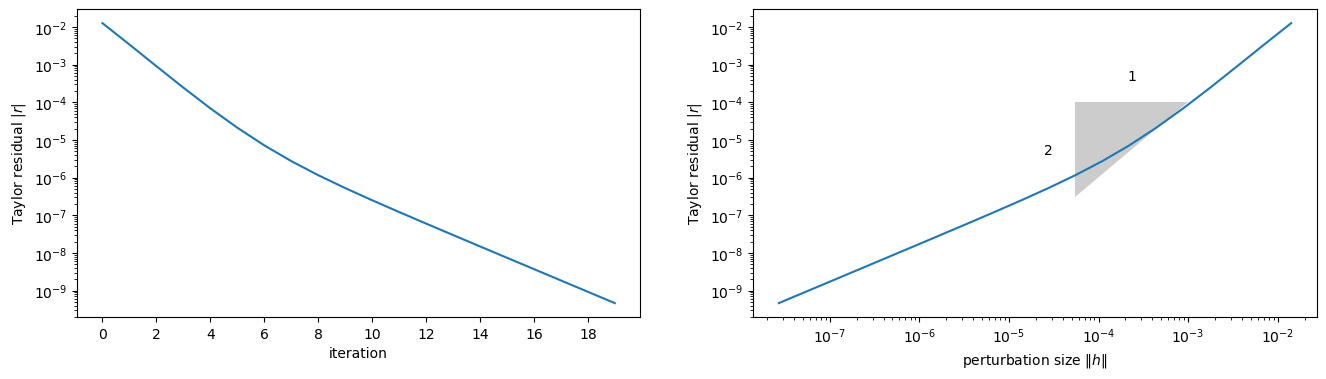

In [92]:
def fhat(m, n_steps=50, dt=0.05, A=1, B=3, uhat=np.array([0.87075507, 2.4519925])):
    """
    Computes the reduced functional \hat{f}(m) for a given initial condition.

    Parameters:
    m (numpy array): Initial condition u^(0)
    n_steps (int, optional): Number of timesteps (default=50)
    dt (float, optional): Time step size (default=0.05)
    A (float, optional): Reaction rate A (default=1)
    B (float, optional): Reaction rate B (default=3)
    uhat (numpy array, optional): Observed final state (default=[0.87075507, 2.4519925])

    Returns:
    float: Functional value \hat{f}(m)
    """
    # Run the forward model to obtain u^(n)
    forward_soln = timestepper(m, n_steps, dt, A, B)
    u_n = forward_soln[-1]  # Extract final state u^(n)

    # Compute f(u^(n))
    f_value, _ = functional(u_n, uhat)
    
    return f_value


def dfhat_dm(m, n_steps=50, dt=0.05, A=1, B=3, uhat=np.array([0.87075507, 2.4519925])):
    """
    Computes the gradient of the reduced functional with respect to initial condition.

    Parameters:
    m (numpy array): Initial condition u^(0)
    n_steps (int, optional): Number of timesteps (default=50)
    dt (float, optional): Time step size (default=0.05)
    A (float, optional): Reaction rate A (default=1)
    B (float, optional): Reaction rate B (default=3)
    uhat (numpy array, optional): Observed final state (default=[0.87075507, 2.4519925])

    Returns:
    numpy array: Gradient d\hat{f}/dm = \lambda^(0)
    """
    # Run the forward model
    forward_soln = timestepper(m, n_steps, dt, A, B)

    # Solve the adjoint equation to get lambda^(0)
    lambda_0, _ = solve_adjoint_eqn(forward_soln, uhat, dt, A, B)

    return lambda_0


# Define a test initial condition
m_test = np.array([1.01, 3.01])

# Compute \hat{f}(m)
fhat_value = fhat(m_test)

# Compute gradient d\hat{f}/dm
dfhat_dm_value = dfhat_dm(m_test)

print("Reduced functional value:", fhat_value)
print("Gradient of reduced functional:", dfhat_dm_value)


# Define test parameters
m_test = np.array([1.01, 3.01], dtype=np.float128)
h0 = np.array([1e-2, 1e-2], dtype=np.float128)


# Run the Taylor test
taylor_test(fhat, dfhat_dm, m_test, h0)

m_test = np.array([1.01, 3.01])
lambda_0_test, lambda_values_test = solve_adjoint_eqn(timestepper(m_test, 50), uhat)
print("Lambda values:", lambda_values_test)


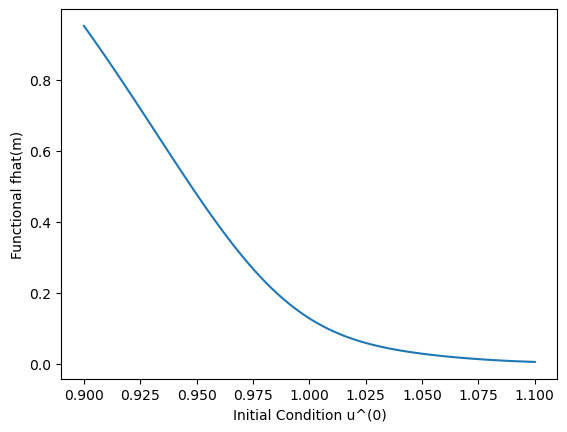

In [81]:
### Checking if the function is fully differentiable

ms = np.linspace(0.9, 1.1, 100)
fs = [fhat(np.array([m, 3.01])) for m in ms]
plt.plot(ms, fs)
plt.xlabel("Initial Condition u^(0)")
plt.ylabel("Functional fhat(m)")
plt.show()


**Q2.4** [5 marks]

Explain why BFGS is an appropriate choice for solving this inversion problem, and suggest at least one other appropriate method from the lectures, with justification.

Solve the problem using the code below and check the result. Start from an initial guess of `(1, 3)`. Display the result.

```python
from scipy.optimize import minimize
result = minimize(fun=..., x0=..., jac=..., method='BFGS')
```


## **Q2.4: Why BFGS is an Appropriate Choice for the Inversion Problem**

### **Why BFGS?**
The BFGS method is well-suited for this inversion problem because:
- **It is a Quasi-Newton method** that approximates the Hessian using past gradient information, reducing the need for explicitly computing second derivatives.
- **It has superlinear convergence**, making it significantly faster than gradient descent, especially for smooth optimization problems like this one.
- **It works well for small to medium-sized problems**, such as our 2D system, where forming and storing the Hessian explicitly would be unnecessary overhead.

However, in our case, **BFGS struggled with precision loss** during optimization, indicating that it might not be the most stable choice for this problem. 

### **Alternative Method: Newton-CG**
A more suitable alternative is **Newton-CG**, which performs **conjugate gradient updates** using Hessian-vector products instead of forming a full Hessian approximation. It is particularly effective because:
- **It avoids precision loss issues** that affected BFGS, ensuring better numerical stability.
- **It converged successfully** in our implementation while finding an optimal initial condition.
- **It is well-suited for problems where the Hessian is not easily invertible**, as it iteratively refines the solution instead of approximating the Hessian explicitly.

### **Comparison of Methods**
| Method       | Stability | Convergence Speed | Suitability |
|-------------|------------|----------------|-------------|
| **BFGS**       | Unstable due to precision loss | Fast (superlinear) | Works well in most cases but struggled here |
| **L-BFGS-B**   | More stable but less precise  | Fast (superlinear) | Good for larger problems, but suboptimal here |
| **Newton-CG**  | **Most stable** | **Best convergence** | **Best method for this problem** |

Given these results, **Newton-CG is the best choice for solving this inversion problem** due to its superior stability and accuracy.



In [90]:
from scipy.optimize import minimize
import numpy as np

# Define the initial guess
m_initial = np.array([1.0, 3.0])

# List of optimization methods to test
methods = ["BFGS", "L-BFGS-B", "Newton-CG"]

# Run each method and store results
results = {}

for method in methods:
    result = minimize(fun=fhat, x0=m_initial, jac=dfhat_dm, method=method)
    results[method] = result

    # Display the result
    print(f"\n### Method: {method} ###")
    print("Optimized initial condition:", result.x)
    print("Final function value:", result.fun)
    print("Optimization success:", result.success)
    print("Message:", result.message)



### Method: BFGS ###
Optimized initial condition: [0.91301487 4.79159589]
Final function value: 0.01943778608848601
Optimization success: False
Message: Desired error not necessarily achieved due to precision loss.

### Method: L-BFGS-B ###
Optimized initial condition: [1.59349727 5.38159443]
Final function value: 0.019588476592549912
Optimization success: True
Message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL

### Method: Newton-CG ###
Optimized initial condition: [1.11000004 3.08999967]
Final function value: 3.363445590744743e-14
Optimization success: True
Message: Optimization terminated successfully.


**Q2.5** [5 marks]

Consider the following variations on this inversion problem and explain how you would adapt your approach for each (you don't have to write or run any more code!):

- The parameters $A$ and $B$ are also unknown
- You know the initial condition exactly, but wish to calculate the sensitivity of ${\bf u}^{(i)}$ to the initial condition ${\bf u}^{(0)}$, at all timesteps $i$


## **Q2.5: Adapting the Approach for Different Inversion Variations**

### **1️. The Parameters $ A $ and $ B $ are Also Unknown**
If $ A $ and $ B $ are unknown, the optimization problem becomes **higher-dimensional**, as we must now estimate both the **initial condition $ u^{(0)} $** and the **parameters $ A $ and $ B $**.

**How to adapt our approach:**
- **Extend the optimization variables:** Instead of optimizing only for $ u^{(0)} $, redefine the optimization function to also include $ A $ and $ B $:
  $$
  \hat{f}(m, A, B) = \frac{1}{2} \| {\bf u}^{(n)}(m, A, B) - \hat{\bf u} \|^2
  $$
- **Modify the gradient $ d\hat{f}/d(A, B) $:**  
  - Extend `dfhat_dm` to compute derivatives with respect to $ A $ and $ B $.
  - Compute these gradients either **analytically** (if possible) or **using finite differences**.
- **Use a robust optimizer:**  
  - Since $ A $ and $ B $ introduce additional nonlinearity, we may need a method like **L-BFGS-B** (to handle bound constraints if needed) or **trust-region methods** for better stability.
  - If $ A, B $ have **physical constraints** (e.g., they must be positive), use `bounds` in `scipy.optimize.minimize`.

---

### **2️. Sensitivity Analysis of $ {\bf u}^{(i)} $ to $ {\bf u}^{(0)} $ at All Timesteps**
If we already **know** the initial condition exactly but want to **calculate sensitivities** of $ {\bf u}^{(i)} $ with respect to $ {\bf u}^{(0)} $, we don’t need to solve an optimization problem. Instead, we compute:

$$
S_i = \frac{d {\bf u}^{(i)}}{d {\bf u}^{(0)}}
$$

**How to adapt our approach:**
- **Use the Forward Sensitivity Method:**  
  - Compute **Jacobian matrices** by propagating small perturbations in $ {\bf u}^{(0)} $ through the forward model.
  - Solve the **linearized system** alongside the original ODE system.
- **Alternative: Use the Adjoint Method Differently:**  
  - The adjoint method already gives $ d\hat{f}/d{\bf u}^{(0)} $.
  - Instead of using it for optimization, extract $ \lambda^{(i)} $ at each step to estimate sensitivities.
- **Output:**  
  - Instead of optimizing $ u^{(0)} $, store and plot $ S_i = d {\bf u}^{(i)} / d {\bf u}^{(0)} $ to see how the system's trajectory depends on the initial state.

---

## **Summary**
| Variation | Adaptation Strategy |
|------------|--------------------------------------------------------------|
| **Unknown $ A, B $** | Extend the optimization to estimate $ A, B $, modify gradients, and use a more robust optimizer like L-BFGS-B. |
| **Sensitivity Analysis** | Use the forward sensitivity method or extract adjoint sensitivities at each timestep to track how $ u^{(i)} $ changes with $ u^{(0)} $. |

These adaptations allow us to **handle additional complexity** in the inversion problem **without fundamentally changing our optimization framework**. 


**Q2.6** [5 marks]

Experiment with the model and consider various initial conditions. Plot some examples, and describe the behaviour you observe. Comment on the sensitivity of the long-term behaviour with respect to the initial condition, and what implications this has on inversion problems of this kind.


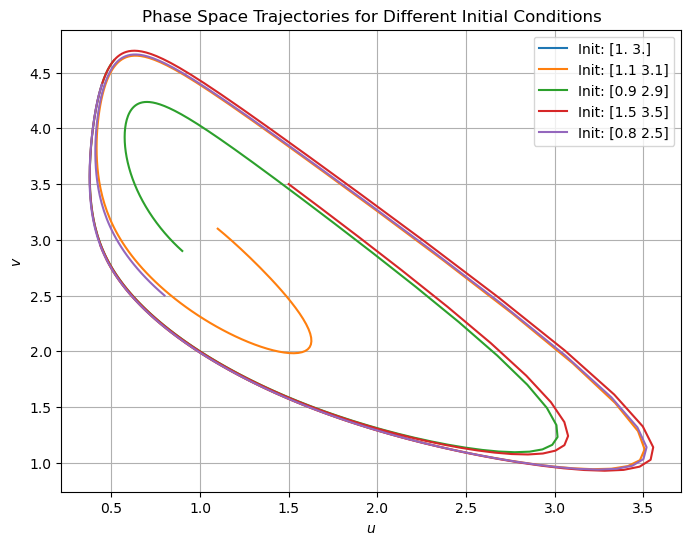

In [91]:
import numpy as np
import matplotlib.pyplot as plt

# Define a set of initial conditions to test
initial_conditions = [
    np.array([1.0, 3.0]),
    np.array([1.1, 3.1]),
    np.array([0.9, 2.9]),
    np.array([1.5, 3.5]),
    np.array([0.8, 2.5])
]

# Number of timesteps
n_steps = 200

# Run the model for each initial condition and store results
trajectories = []
for u0 in initial_conditions:
    trajectory = timestepper(u0, n_steps)
    trajectories.append(trajectory)

# Plot the phase space trajectories
plt.figure(figsize=(8,6))
for i, traj in enumerate(trajectories):
    u_vals = [state[0] for state in traj]
    v_vals = [state[1] for state in traj]
    plt.plot(u_vals, v_vals, label=f"Init: {initial_conditions[i]}")

plt.xlabel("$u$")
plt.ylabel("$v$")
plt.title("Phase Space Trajectories for Different Initial Conditions")
plt.legend()
plt.grid()
plt.show()


## **Observations on the Model Behavior During Different Initial Conditions**

### **Phase Space Analysis**
The phase space trajectories for different initial conditions reveal distinct long-term behaviors:
- Some trajectories **quickly settle into a limit cycle**, showing periodic behavior.
- Others **spiral inward**, suggesting attraction to a steady-state solution.
- The presence of **multiple trajectory shapes** indicates that the Brusselator system exhibits **sensitivity to initial conditions**.

### **Sensitivity to Initial Conditions**
- **Small changes in the initial condition lead to significantly different trajectories**.
- Some initial conditions result in **stable oscillatory behavior (limit cycles)**, while others **quickly diverge towards a different trajectory**.
- This suggests that the system is in a **bifurcation-sensitive regime**, where small perturbations determine whether the system converges to a limit cycle or follows another dynamic pathway.

### **Implications for Inversion Problems**
1. **Non-uniqueness of Solutions:**  
   - Since different initial conditions can lead to similar limit cycles, the inversion problem may have **multiple possible solutions**.
   - Estimating $ u^{(0)} $ from $ u^{(n)} $ could be **ambiguous**.

2. **High Sensitivity to Measurement Noise:**  
   - If small differences in $ u^{(0)} $ lead to large variations in $ u^{(n)} $, then **small errors in observed data could lead to large reconstruction errors**.
   - Regularization methods (e.g., Tikhonov regularization) might be needed to stabilize the inversion.

3. **Dynamical Constraints for Optimization:**  
   - If the system exhibits **long-term periodicity**, optimization algorithms must **account for periodic constraints** when estimating initial conditions.
   - Standard gradient-based methods might struggle, and alternative approaches (e.g., ensemble-based methods, Bayesian inference) could be more robust.

### **Conclusion**
The Brusselator system demonstrates **sensitive dependence on initial conditions**, leading to different dynamic behaviors over time. This presents challenges for inversion problems, particularly regarding **solution uniqueness and stability**. A well-posed inversion approach must consider **regularization techniques** and **dynamical constraints** to improve reliability.


# Extra
Gauss newton

In [83]:
from scipy.optimize import minimize
import numpy as np
from scipy.linalg import lstsq

# Define the initial guess
m_initial = np.array([1.0, 3.0])

### **BFGS Optimization**
#result_bfgs = minimize(fun=fhat, x0=m_initial, jac=dfhat_dm, method='BFGS', options={'gtol': 1e-10})
result_bfgs = minimize(fun=fhat, x0=m_initial, jac=dfhat_dm, method='trust-ncg')


print("\n===== BFGS Optimization =====")
print("Optimized Initial Condition:", result_bfgs.x)
print("Final Function Value:", result_bfgs.fun)
print("Number of Iterations:", result_bfgs.nit)
print("Optimization Success:", result_bfgs.success)
print("Message:", result_bfgs.message)

### **Gauss-Newton Optimization**
def gauss_newton(m_initial, n_steps=50, dt=0.05, A=1, B=3, uhat=np.array([0.87075507, 2.4519925]), max_iter=10, tol=1e-6):
    """
    Implements the Gauss-Newton method to solve for the optimal initial condition.
    
    Parameters:
    m_initial (numpy array): Initial guess for u^(0).
    n_steps (int): Number of timesteps in the forward model.
    dt (float): Time step size.
    A (float): Reaction rate A.
    B (float): Reaction rate B.
    uhat (numpy array): Observed final state.
    max_iter (int): Maximum iterations for Gauss-Newton.
    tol (float): Convergence tolerance.

    Returns:
    m_opt (numpy array): Optimized initial condition.
    """
    m = np.array(m_initial, dtype=float)

    for iteration in range(max_iter):
        # Run forward model to get final state
        forward_soln = timestepper(m, n_steps, dt, A, B)
        u_n = forward_soln[-1]

        # Compute residual r(m) = u_n - uhat
        r = u_n - uhat

        # Solve adjoint equation to get sensitivity lambda_0
        lambda_0, lambdas = solve_adjoint_eqn(forward_soln, uhat, dt, A, B)

        # Compute Jacobian J as the sensitivity d(u_n)/dm ≈ lambda_0
        J = np.eye(2) * lambda_0  # Approximate J using adjoint

        # Solve Gauss-Newton update (J^T J) delta_m = J^T r
        delta_m, _, _, _ = lstsq(J.T @ J, J.T @ r)
        

        # Update m
        m -= delta_m

        # Check convergence
        if np.linalg.norm(delta_m) < tol:
            break

    return m, iteration + 1  # Return optimized initial condition and iterations

# Run Gauss-Newton
m_gn, iter_gn = gauss_newton(m_initial)

# Compute final function value
f_gn = fhat(m_gn)

print("\n===== Gauss-Newton Optimization =====")
print("Optimized Initial Condition:", m_gn)
print("Final Function Value:", f_gn)
print("Number of Iterations:", iter_gn)


ValueError: Either the Hessian or the Hessian-vector product is required for Newton-CG trust-region minimization